In [830]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
from xgboost import plot_importance

# CARICAMENTO DATASET e PULIZIA

In [831]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Info

In [832]:
print("Shape del dataset:", df.shape)

print("\n--- Info ---")
print(df.info())

print("\n--- Descrizione ---")
print(df.describe())

print("\n--- Numero valori nulli ---")
print(df.isnull().sum())

print("\n--- Righe duplicate ---")
print(df[df.duplicated()])

Shape del dataset: (891, 12)

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

--- Descrizione ---
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2

## Rimuovo 'Embarked' vuoti

Nel dataset del Titanic, la colonna Embarked indica il porto di imbarco del passeggero:
- S = porto principale di partenza del Titanic - Southampton, Inghilterra (la maggior parte dei passeggeri)
- C = porto di Cherbourg, Francia (molti passeggeri di 1ª classe)
- Q = porto Queenstown (oggi Cobh), Irlanda (molti passeggeri di 3ª classe)

In [833]:
df_clean = df.dropna(subset=["Embarked"]).copy()

print("\n--- Numero valori nulli ---")
print(df_clean.isnull().sum())


--- Numero valori nulli ---
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


## Media per 'Age' vuoti

In [834]:
# Sto modificando un DF che deriva da un sottoinsieme di un altro -> modifico le colonne con .loc 
df_clean.loc[:, "Age"] = df["Age"].fillna(df["Age"].mean())

print("\n--- Numero valori nulli ---")
print(df_clean.isnull().sum())


--- Numero valori nulli ---
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


## "Not assigned" per 'Cabin' NaN

In [835]:
# Sto modificando un DF che deriva da un sottoinsieme di un altro -> modifico le colonne con .loc 
df_clean.loc[:, "Cabin"] = df["Cabin"].fillna("Not assigned")

print("\n--- Numero valori nulli ---")
print(df_clean.isnull().sum())


--- Numero valori nulli ---
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


## Elimino sigla in 'Ticket'

Prefissi:
- A/5, A/4 -> Codici per biglietti di emigrazione a basso costo
- STON/O2. -> Biglietti venduti dalla compagnia Stonehouse per emigranti
- PC -> “Pontchartrain”  ->  agenzia di prima classe, biglietti molto costosi
- S.O./P.P. -> “State Official / Paid Passage” (passaggi pagati dallo Stato)
- C.A. -> Biglietti di Cabin Class (spesso 2ª classe superiore)
- W./C. -> White Star Line (la compagnia proprietaria del Titanic)

Numeri semplici:
- biglietti standard, spesso per terza classe

Ogni ticket identifica:
- famiglie o gruppi che hanno viaggiato insieme -> (stesso ticket  ->  stessa cabina  ->  stessa probabilità di sopravvivenza)
- categorie sociali/economiche
- classi diverse dal numero “Pclass”



In [836]:
# Estraggo il prefisso -> qualunque cosa non numerica all'inizio
df_clean.loc[:, "TicketPrefisso"] = df_clean["Ticket"].str.extract(r"^(.*\D)\d+$")

# Riempio i NaN (cioè ticket senza prefisso) con "Not assigned"
df_clean.loc[:, "TicketPrefisso"] = df_clean["TicketPrefisso"].fillna("Not assigned").str.strip()

# Estraggo solo il numero del ticket
df_clean.loc[:, "TicketNum"] = df_clean["Ticket"].str.extract(r"(\d+)$")

df_clean.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketPrefisso,TicketNum
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Not assigned,S,A/5,21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Not assigned,S,STON/O2.,3101282
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Not assigned,113803
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Not assigned,S,Not assigned,373450


## Nuove Info

In [837]:
print("Shape del dataset:", df_clean.shape)

print("\n--- Info ---")
print(df_clean.info())

Shape del dataset: (889, 14)

--- Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     889 non-null    int64  
 1   Survived        889 non-null    int64  
 2   Pclass          889 non-null    int64  
 3   Name            889 non-null    object 
 4   Sex             889 non-null    object 
 5   Age             889 non-null    float64
 6   SibSp           889 non-null    int64  
 7   Parch           889 non-null    int64  
 8   Ticket          889 non-null    object 
 9   Fare            889 non-null    float64
 10  Cabin           889 non-null    object 
 11  Embarked        889 non-null    object 
 12  TicketPrefisso  889 non-null    object 
 13  TicketNum       885 non-null    object 
dtypes: float64(2), int64(5), object(7)
memory usage: 104.2+ KB
None


## Rimuovo 'TicketNum' vuoti

In [838]:
df_new = df_clean.dropna(subset=["TicketNum"]).copy()
df_new["TicketNum"] = df_new["TicketNum"].astype(float)

print("\n--- Numero valori nulli ---")
print(df_new.isnull().sum())


--- Numero valori nulli ---
PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin             0
Embarked          0
TicketPrefisso    0
TicketNum         0
dtype: int64


## Vedo se vanno in famiglia o sono soli, e il titolo che hanno

In [839]:
df_new["FamilySize"] = df_new["SibSp"] + df_new["Parch"] + 1
df_new["IsAlone"] = (df_new["FamilySize"] == 1).astype(int)

df_new["Title"] = df_new["Name"].str.extract(r',\s([^.]).')
rare_titles = ["Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"]
df_new["Title"] = df_new["Title"].replace(rare_titles, "Rare")

df_new.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketPrefisso,TicketNum,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Not assigned,S,A/5,21171.0,2,0,M
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599.0,2,0,M
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Not assigned,S,STON/O2.,3101282.0,1,1,M
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Not assigned,113803.0,2,0,M
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Not assigned,S,Not assigned,373450.0,1,1,M


## Estraggo il ponte delle cabine

In [840]:
df_new["Deck"] = df_new["Cabin"].astype(str).str[0]
df_new.loc[df_new["Deck"] == "N", "Deck"] = "Unknown"

df_new.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketPrefisso,TicketNum,FamilySize,IsAlone,Title,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Not assigned,S,A/5,21171.0,2,0,M,Unknown
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599.0,2,0,M,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Not assigned,S,STON/O2.,3101282.0,1,1,M,Unknown
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Not assigned,113803.0,2,0,M,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Not assigned,S,Not assigned,373450.0,1,1,M,Unknown


## Elimino le colonne che ho usato per creare quelle nuove

In [841]:
df_model = df_new.drop(columns=["PassengerId", "Name", "Cabin", "Ticket"])

print(df_model.shape)
df_model.head()

(885, 14)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,TicketPrefisso,TicketNum,FamilySize,IsAlone,Title,Deck
0,0,3,male,22.0,1,0,7.2500,S,A/5,21171.0,2,0,M,Unknown
1,1,1,female,38.0,1,0,71.2833,C,PC,17599.0,2,0,M,C
2,1,3,female,26.0,0,0,7.9250,S,STON/O2.,3101282.0,1,1,M,Unknown
3,1,1,female,35.0,1,0,53.1000,S,Not assigned,113803.0,2,0,M,C
4,0,3,male,35.0,0,0,8.0500,S,Not assigned,373450.0,1,1,M,Unknown


## Dummies

In [842]:
df_model = pd.get_dummies(df_model, columns=["Sex", "Embarked", "TicketPrefisso", "Title", "Deck"], drop_first=True)

print(df_model.shape)
df_model.head()

(885, 70)


,Survived,Pclass,Age,SibSp,Parch,Fare,TicketNum,FamilySize,IsAlone,Sex_male,...,Title_S,Title_t,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown
0,0,3,22.0,1,0,7.2500,21171.0,2,0,True,...,False,False,False,False,False,False,False,False,False,True
1,1,1,38.0,1,0,71.2833,17599.0,2,0,False,...,False,False,False,True,False,False,False,False,False,False
2,1,3,26.0,0,0,7.9250,3101282.0,1,1,False,...,False,False,False,False,False,False,False,False,False,True
3,1,1,35.0,1,0,53.1000,113803.0,2,0,False,...,False,False,False,True,False,False,False,False,False,False
4,0,3,35.0,0,0,8.0500,373450.0,1,1,True,...,False,False,False,False,False,False,False,False,False,True


# TRAINING

## Split

In [843]:
X = df_model.drop(columns=["Survived"])
y = df_model["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## XGBoost

In [844]:
# Parametri da testare
estimators = [100, 200, 300]
depth = [3, 5, 7]

results = []

# Loop su tutte le combinazioni
for n_estimators in estimators:
    for max_depth in depth:

        model = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            eval_metric="logloss"
        )
        
        # Training
        model.fit(X_train, y_train)
        
        # Predizione
        preds = model.predict(X_test)
        
        # Calcolo metriche
        acc = accuracy_score(y_test, preds)
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, preds)
        
        # Salvo i risultati
        results.append({
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "Accuracy": acc,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2
        })
        
# Converto in DataFrame per visualizzare come tabella
results_df = pd.DataFrame(results)
display(results_df.style.hide(axis="index"))

n_estimators,max_depth,Accuracy,MSE,RMSE,R2
100,3,0.807910,0.192090,0.438281,0.220668
100,5,0.807910,0.192090,0.438281,0.220668
100,7,0.807910,0.192090,0.438281,0.220668
200,3,0.802260,0.197740,0.444680,0.197747
200,5,0.807910,0.192090,0.438281,0.220668
200,7,0.802260,0.197740,0.444680,0.197747
300,3,0.807910,0.192090,0.438281,0.220668
300,5,0.813559,0.186441,0.431788,0.243590
300,7,0.807910,0.192090,0.438281,0.220668


## Modello migliore -> 'accuracy' alta

In [845]:
# Ordino per Accuracy decrescente
results_df_sorted = results_df.sort_values(by="Accuracy", ascending=False)

print("MODELLI ORDINATI PER MIGLIORE PUNTEGGIO DI ACCURACY")
display(results_df_sorted.style.hide(axis="index"))

MODELLI ORDINATI PER MIGLIORE PUNTEGGIO DI ACCURACY


n_estimators,max_depth,Accuracy,MSE,RMSE,R2
300,5,0.813559,0.186441,0.431788,0.243590
100,3,0.807910,0.192090,0.438281,0.220668
100,5,0.807910,0.192090,0.438281,0.220668
100,7,0.807910,0.192090,0.438281,0.220668
200,5,0.807910,0.192090,0.438281,0.220668
300,3,0.807910,0.192090,0.438281,0.220668
300,7,0.807910,0.192090,0.438281,0.220668
200,3,0.802260,0.197740,0.444680,0.197747
200,7,0.802260,0.197740,0.444680,0.197747


# GRAFICI

## Features più importanti

Le feature mostrate come più importanti sono quelle che hanno contribuito maggiormente al modello durante il training secondo un certo criterio interno di XGBoost

<Figure size 1000x600 with 0 Axes>

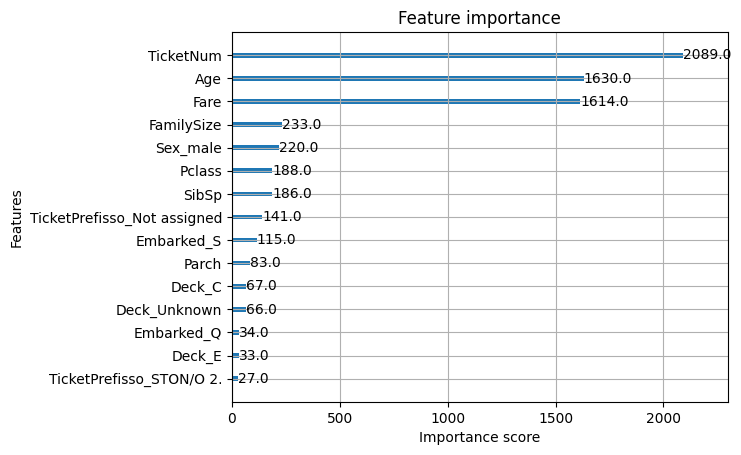

In [846]:
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=15) # mostra le 15 più importanti

plt.show()

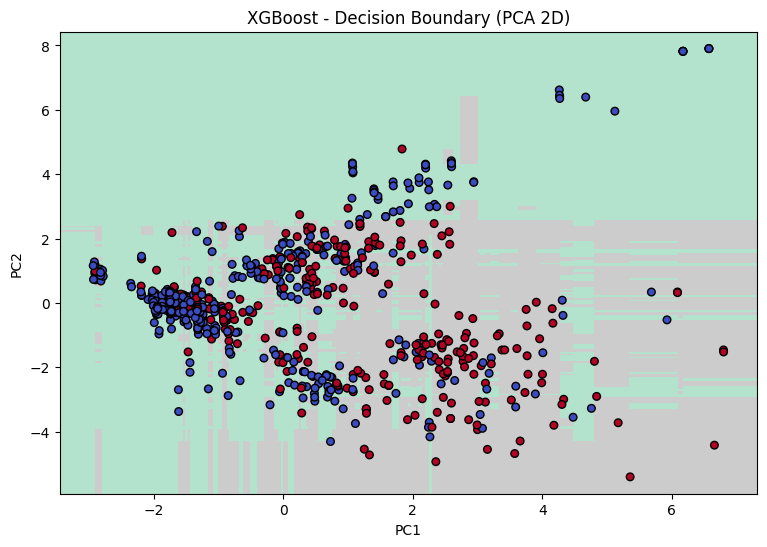

In [ ]:
features = [
    "Pclass", "Age", "SibSp", "Parch", "Fare", "TicketNum", "FamilySize", "IsAlone",
    "Sex_male", "Embarked_Q", "Embarked_S"
] + [col for col in df_model.columns if col.startswith("TicketPrefisso_")] \
  + [col for col in df_model.columns if col.startswith("Title_")] \
  + [col for col in df_model.columns if col.startswith("Deck_")]

X = df_model[features].astype(float)
y = df_model["Survived"]

# Normalizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA a 2 componenti
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Train XGBoost
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)
xgb.fit(X_pca, y)

# Creazione griglia decisionale
x_min, x_max = X_pca[:, 0].min() - 0.5, X_pca[:, 0].max() + 0.5
y_min, y_max = X_pca[:, 1].min() - 0.5, X_pca[:, 1].max() + 0.5

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = xgb.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot finale
plt.figure(figsize=(9, 6))
plt.pcolormesh(xx, yy, Z, cmap="Pastel2", shading='auto')

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="coolwarm", edgecolor='k', s=30)

plt.title("XGBoost - Decision Boundary (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()